# Quantum Monte Carlo on Quantum Computers

In the previous notebook, we have extensively discussed the motivation for incorporating quantum computing into the classical QMC algorithms for better accuracy. And we have explored using vacuum reference circuits to evaluate $\langle\Psi_Q|\phi\rangle, \langle\Psi_Q|H|\phi\rangle$ at every timestep of the imaginary time evolution process. In this notebook, we are going to investigate an alternative approach--classical shadows [1], to evaluate these intermediate quantities on classical computers.

<div class="alert alert-block alert-info">
<b>Note:</b> The code in this notebook has option to use multiprocessing for computations. A notebook instance with multiple CPU cores is required to use multiprocessing. With a ml.m5.24xlarge notebook instance, the code takes about 260 minutes in total to run in this notebook, which will incur charge for about \$24.0 USD. 

The notebook also creates a Braket job to compute a scaled-up QMC workload that takes about 24 hours with a ml.m5.24xlarge job instance, which will incur charge for about \$134.2 USD. Please proceed with caution for this section.
</div>

In [1]:
import time
import numpy as np
import pennylane as qml
from typing import Callable, List, Tuple

np.set_printoptions(precision=6, edgeitems=10, linewidth=150, suppress=True)

In [2]:
# define the ansatz circuit

def V_T():
    qml.DoubleExcitation(0.12, wires=[0,1,2,3])

In [3]:
###########################################################
# Prepare the necessary operators for AFQMC calculations. #
###########################################################

from pyscf import fci, gto, scf
from afqmc.utils.chemical_preparation import chemistry_preparation

# perform HF calculations
mol = gto.M(atom="H 0. 0. 0.; H 0. 0. 0.75", basis="sto-3g")
hf = mol.RHF()
hf.kernel()

# perform full configuration interaction (FCI) calculations
myci = fci.FCI(hf)
myci.kernel()

prop = chemistry_preparation(mol, hf)

converged SCF energy = -1.1161514489386


## Part I. Classical shadows

Estimating properties of unknown quantum states is a key objective of quantum information science and technology. As in our example case, we are seeking $\langle\Psi_Q|\phi\rangle$ and $\langle\Psi_Q|H|\phi\rangle$ where $|\Psi_Q\rangle$ is prepared on the quantum computer. However, conventional approach for calculating these quantities like quantum state tomography [2] usually requires a substantial amount of measurements. 

Classical shadow is an alternative way to efficiently (but approximately) estimate expectation values of many physical observables with respect to an unknown quantum state $\rho$ on classical computers [1]. The protocol involves randomized measurements (random unitary rotation $U$ and projective measurements outcome $|b\rangle$) to reconstruct the unknown quantum state

$$
\rho = \mathbb{E}_{U\sim \mathcal{D}} \left[\mathcal{M}^{-1} \left(U^\dagger|b\rangle\langle b| U\right)\right],
$$

where the random unitary $U$ is sampled from certain distribution $\mathcal{D}$, and $\mathcal{M}$ represents the quantum channel that maps $\rho$ to $U^\dagger|b\rangle\langle b|U$. A schematic representation of the shadow protocol is shown in the figure below.

<figure style="text-align: center;">
    <img src="images/classical_shadow_overview.png" width="800">
    <figcaption>Image from Huang et al. [2].</figcaption>
</figure>

To estimate each expectation value within error $\epsilon$ with probability at least $1 − \delta$, it requires a number of measurements that scale logarithmically with the number of observables $M$ as
$$
N_\text{sample} = O\left(\frac{\text{log}(M/\delta)}{\epsilon^2} \max_{1<i<M} \text{Var}[\hat{o}_i]\right),
$$

where $\text{Var}[\hat{o}_i]$ represents the variance of estimator $\hat{o}_i = \text{tr}(O_i\rho)$. For more details of shadow tomography, check Ref. [1] and this [PennyLane demo](https://pennylane.ai/qml/demos/tutorial_classical_shadows).


One characteristic of the QC-AFQMC algorithm that makes classical shadow particularly appealling is that the quantum trial state, i.e., $|\Psi_Q\rangle$ (as the only quantum computing component), doesn't change during the evolution of the algorithm. If we apply shadow protocol on top of $|\Psi_Q\rangle$ at the beginning of the calculation, the measured classical shadows can be kept in classical memory and re-used for all $|\phi_l\rangle$. This would rescue the QC-AFQMC algorithm from iterative communication between quantum and classical hardware. To fit the overlap $\langle\Psi_Q|\phi\rangle$ into the shadow tomography framework, we re-write it into the expectation value of an observable as

$$
\langle \Psi_Q|\phi\rangle = 2 \text{tr}\left(|\phi\rangle \langle \mathbf{0}| \rho\right),
$$

where $\rho$ represents the density matrix of $\frac{1}{\sqrt{2}}\left(|\Psi_Q\rangle + |\mathbf{0}\rangle\right)$, and $|\mathbf{0}\rangle$ represents the all-0 state. For the shadow protocol to recover these overlaps, we use specifically the Matchgate circuit ($U$) for random rotation, because it has been shown to result in efficient classical post-processing [3]. The actual classical post-processing is a little bit involved, and has a $O(N^4)$ scaling with respect to system sizes $N$ [3]. We will not go over the computation details here, but direct the interested reader to look at Sec. 3.3.3 of Ref. [3] or App. D in Ref. [4] for derivations and the `ovlp_construction` function in the following folder `afqmc/utils/matchgate` for its implementation. We would like to emphasize that in post-processing the classical shadows, we have used the [Numba](https://numba.pydata.org/) package to accelerate the massive matrix operations. You might also consider using GPUs to accelerate this process, which we leave to the motivated readers.


Then we look at the slightly more complicated case--mixed estimator of the Hamiltonian $\langle \Psi_Q|H|\phi\rangle$. A direct workaround is to think of $H$ as a linear combination of $O(N^4)$ number of excitation operators, and re-express $H|\phi\rangle = \sum_j|\phi_j\rangle$. Then the estimator can be converted to $\sum_j \langle\Psi_Q|\phi_j\rangle$. Each overlap in this sum can be estimated via the classical shadows. We direct the interested readers to App. B in Ref. [4] for more details. Therefore, we see that both quantities can be reformulated to fit into shadow tomography, and we can benefit from the desirable scaling of quantum resource. 


One drawback of the classical shadow's approach for QC-AFQMC, despite significant savings in the quantum computing resources, is that it increases the classical post-processing cost from $O(N^3)$ to $O(N^{8.5})$ [4]. This limits the algorithm to only small system sizes. We note that Ref. [5,6] have proposed better classical post-processing routines that leverage algorithmic differentiation to reduce the scaling to $O(N^{5.5})$. In this tutorial, we stick to the relatively high scaling implementation proposed in Ref. [3], and leave it to the readers to explore the more advanced solution.

In [4]:
########################################################################
# Define a function to construct shadow circuits for hydrogen molecule #
########################################################################

from afqmc.utils.matchgate import gaussian_givens_decomposition

num_qubits = 4
dev = qml.device("lightning.qubit", wires=num_qubits, shots=100)
@qml.qnode(dev)
def hydrogen_shadow_circuit(Q):
    '''This function constructs the matchgate shadow circuit from random signed permutation matrix
    Args:
        Q (np.ndarray): random signed permutation matrix.
    Returns:
        qml.counts(): measurement outcomes
    '''
    qml.Hadamard(wires=0)
    qml.CNOT(wires=[0, 1])
    V_T()
    
    # Apply random rotation for shadow tomography
    gaussian_givens_decomposition(Q)
    return qml.counts()

/home/ec2-user/SageMaker/QC-QMC/afqmc/utils/matchgate.py:197: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (Array(complex128, 2, 'C', False, aligned=True), Array(complex128, 2, 'A', False, aligned=True))
  COMP = W.conj() @ Q_tilde.T @ Q.T @ b_cov @ Q @ Q_tilde @ W.conj().T


After defining the quantum circuits used for shadow tomography, we go ahead and collect these measurement outcomes. We will also use the PennyLane simulator as the backend for running these circuits.

In [5]:
###################################################
# Construct shadow circuits for hydrogen molecule #
###################################################

from afqmc.utils.shadow import random_signed_permutation
from afqmc.utils.shadow import calculate_classical_shadow

# we will sample 4000 shadow circuits here
shadow_size = 4000

Q_list = []
for _ in range(shadow_size):
    Q_list.append(random_signed_permutation(2*num_qubits))

In [6]:
%%time

outcomes = calculate_classical_shadow(hydrogen_shadow_circuit, Q_list)
shadow = (outcomes, Q_list)

CPU times: user 17 s, sys: 7.46 ms, total: 17 s
Wall time: 17 s


In the above code cell, we used the PennyLane embedded `lightning.qubit` simulator to collect shadows. For real quantum hardware, we can leverage another feature called [program sets](https://aws.amazon.com/blogs/quantum-computing/amazon-braket-introduces-program-sets-enabling-customers-to-run-quantum-programs-up-to-24x-faster/) for faster run times. The code using PennyLane is provided below.

<div class="alert alert-block alert-info">
<b>Note:</b> The following code cell will incur charge for about \$372 USD on the Rigetti device.
</div>

In [ ]:
# rigetti_dev = qml.device(
#     "braket.aws.qubit",
#     device_arn="arn:aws:braket:us-west-1::device/qpu/rigetti/Ankaa-3",
#     wires=4,
#     shots=100,
# )

# tape_generator = qml.workflow.construct_tape(hydrogen_shadow_circuit)
# tapes = []
# for Q in Q_list:
#     tape = tape_generator(Q)
#     tapes.append(tape)
    
# #qml.execute() will automatically trigger program sets
# results = qml.execute(tapes, dev)

## Part II. Calculating the ground state of H$_2$

With all the classical shadows collected, we proceed to execute the AFQMC subroutine. As usual, we start by constructing the quantum trial state $|\Psi_Q\rangle$.

In [7]:
from afqmc.trial_wavefunction.quantum_ovlp import QTrial
from afqmc.qmc.quantum_shadow import cqa_afqmc

## reference
psi0 = np.array([[1,0], [0,1], [0,0], [0,0]])
Angstrom_to_Bohr = 1.88973

symbols = ["H", "H"]
geometry = np.array([[0., 0., 0.], [0., 0., 0.75*Angstrom_to_Bohr]])
hamiltonian, _ = qml.qchem.molecular_hamiltonian(symbols, geometry, charge=0, basis='sto-3g')

qtrial = QTrial(prop=prop, initial_state=[0, 1], ansatz_circuit=V_T, ifshadow=True, shadow=shadow)

<div class="alert alert-block alert-info">
<b>Note</b> The following cell of QC-AFQMC calculation will take about 260 minutes with 48 core parallelization. You may need to execute the notebook on a notebook instance with more than 2 CPU cores to utilize multi-core parallelization. We executed this notebook on a m5.24xlarge instance.
</div>

In [ ]:
%%time

dtau = 0.005
num_steps = 100
num_walkers = 1440

quantum_energies = cqa_afqmc(
    num_walkers,
    num_steps,
    dtau,
    qtrial,
    hamiltonian,
    psi0,
    max_pool=48,
)

CPU times: user 1min 5s, sys: 3.84 s, total: 1min 9s
Wall time: 4h 15min 7s


### Classical AFQMC

We also perform a classical AFQMC calculation for better comparisons. And the procedure is identical to what has been shown in the previous notebook.

In [12]:
%%time
from afqmc.trial_wavefunction.single_slater import SingleSlater
from afqmc.qmc.classical import classical_afqmc

dtau = 0.005
num_steps = 600
num_walkers = 1440
trial = SingleSlater(prop, psi0)

local_energies, energies = classical_afqmc(
    num_walkers,
    num_steps,
    dtau,
    trial,
    prop,
    max_pool=48,
)

CPU times: user 1.82 s, sys: 964 ms, total: 2.78 s
Wall time: 3min 31s


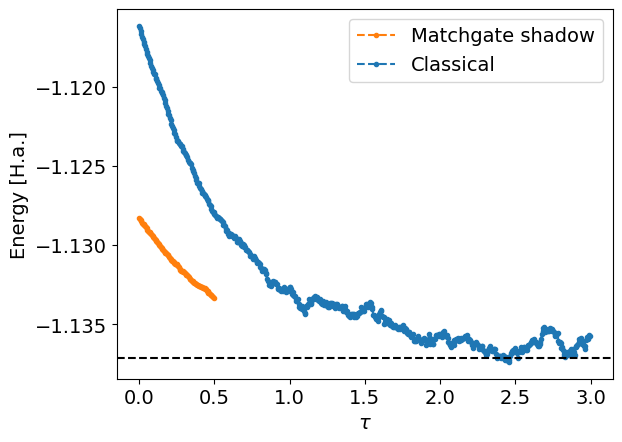

In [17]:
import matplotlib.pyplot as plt

plt.plot(
    dtau * np.arange(100),
    quantum_energies,
    linestyle="dashed",
    marker=".",
    color="tab:orange",
    label="Matchgate shadow",
)
plt.plot(
    dtau * np.arange(600),
    energies,
    linestyle="dashed",
    marker=".",
    color="tab:blue",
    label="Classical",
)
plt.axhline(-1.137117067345732, linestyle="dashed", color="black")
plt.legend(fontsize=14, loc="best")
plt.xlabel(r"$\tau$", fontsize=14)
plt.ylabel("Energy [H.a.]", fontsize=14)
plt.tick_params(labelsize=14)
plt.show()

The Matchgate shadow results shouldn't look much different from the quantum results with vacuum reference circuits that we obtained in the previous lab. And this is within our expectation, since they only differ by means to evaluate these intermediate quantities $\langle\Psi_Q|\phi_l\rangle$, $\langle\Psi_Q|H|\phi_l\rangle$, but the end results should almost be identical (shadow tomography is approximate but the deviation should be small). One thing you may have noticed is that it takes longer time to run the same number of time steps with Matchgate shadows. This is because at this small scale with only 4 qubits, the simulator running quantum circuits is much faster than the classical post-processing of shadows.

To run a full time QC-AFQMC with shadows, you can use Hybrid Jobs to collect the classical shadows. Hybrid Jobs is particularly useful when you consider running this experiment on a QPU because it provides you access to the priority queue. As for the classical post-processing, you might consider a HPC service like [AWS Batch](https://aws.amazon.com/batch/) to take advantage of the embarrassingly parallelizable property of QMC. This is not the scope of this tutorial.


## Part III. Scaling the computation with Hybrid Jobs

Hybrid Jobs, strictly speaking, is no longer a proper choice to run the classical post-processing since there is no quantum computation at this step. In the next few cells, we submit a full time QC-AFQMC hybrid job with the shadow's approach just as a proof of concept. You can compare the result from shadows with that from the previous notebook and they shouldn't differ much.


<div class="alert alert-block alert-info">
<b>Note</b> The following cell of QC-AFQMC Braket hybrid job will take about 24.3 hours with 48 core parallelization. Please proceed with caution.
</div>

In [15]:
# from braket.aws import AwsQuantumJob
# from braket.jobs.config import InstanceConfig

# job = AwsQuantumJob.create(
#     device="local:pennylane/lightning.qubit",
#     source_module="afqmc",
#     entry_point="afqmc.run_matchgate_shadow:run",
#     job_name=f"matchgate-shadow-" + str(int(time.time())),
#     instance_config=InstanceConfig(instanceType="ml.m5.24xlarge"),
#     hyperparameters={
#         "num_shadows": 4000,
#         "shots": 100,
#         "num_walkers": 1440,
#         "num_steps": 600,
#         "dtau": 0.005,
#         "max_pool": 48,
#     },
# )

In [18]:
# result = job.result()
# elapsed = result["elapsed"]
# print(f"Elapsed time of job: {round(elapsed/60,1)} mins")

Elapsed time of job: 1456.1 mins


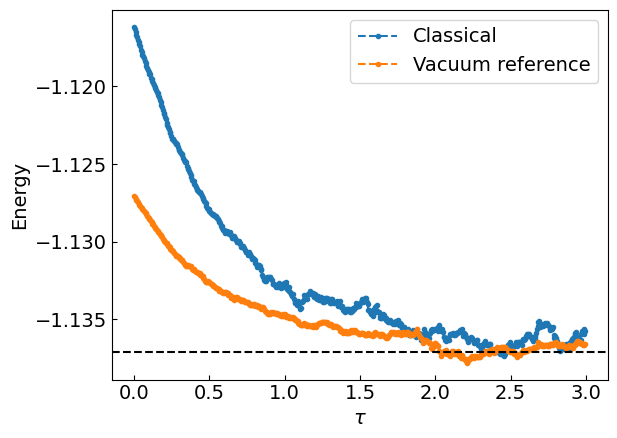

In [19]:
# %matplotlib inline
# plt.plot(
#     dtau * np.arange(600),
#     energies,
#     linestyle="dashed",
#     marker=".",
#     color="tab:blue",
#     label="Classical",
# )
# plt.plot(
#     dtau * np.arange(600),
#     result["quantum_energies"],
#     linestyle="dashed",
#     marker=".",
#     color="tab:orange",
#     label="Vacuum reference",
# )
# plt.axhline(-1.137117067345732, linestyle="dashed", color="black")
# plt.legend(fontsize=14, loc="upper right")
# plt.xlabel(r"$\tau$", fontsize=14)
# plt.ylabel("Energy", fontsize=14)
# plt.yticks(fontsize=14)
# plt.tick_params(direction="in", labelsize=14)
# plt.show()

<div class="alert alert-block alert-info">
<b>Note:</b> The long runtime is because we're limited to only 96 vCPUs on a single m5.24xlarge instance in this tutorial. As we stated earlier, you can significantly reduce the runtime by leveraging multiple instances to parallelize every walker in the AFQMC post-processing.
</div>

## Conclusion


This notebook demonstrates how classical algorithms for quantum Monte Carlo can be augmented with quantum hardware. We explored a variant of QMC, auxiliary-field quantum Monte Carlo, which finds the ground state by performing a stochastic imaginary time evolution of an input state. This evolution is driven by computing the overlaps between a predefined trial state, and an ensemble of non-interacting walker states.

Using a quantum device, we can use a more flexible trial state, which may provide a better approximation to the ground state. We illustrated how the overlaps between the quantum trial state and classical walker states can be evaluated using quantum circuits on quantum backend that can be accessed with Amazon Braket. 

We also illustrated the classical and quantum AFQMC algorithms by applying them to the hydrogen molecule. Even for this toy system, the quantum assisted approach realized quantifiable benefits by reducing the variance of the calculated energy.

We expect that for larger system sizes, QC-AFQMC algorithm will also reduce the bias in ground state energies compared to purely classical AFQMC. 

Overall, quantum-assisted quantum Monte Carlo is a new and interesting route to potentially achieve quantum benefits for chemical calculations.

## References

[1] Huang, Hsin-Yuan, Richard Kueng, and John Preskill. "Predicting many properties of a quantum system from very few measurements." [Nature Physics 16.10 (2020): 1050-1057](https://www.nature.com/articles/s41567-020-0932-7).

[2] Vogel, K., and H. Risken. "Determination of quasiprobability distributions in terms of probability distributions for the rotated quadrature phase." [Physical Review A 40.5 (1989): 2847](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.40.2847).

[3] Wan, Kianna, et al. "Matchgate shadows for fermionic quantum simulation." [Communications in Mathematical Physics 404.2 (2023): 629-700](https://link.springer.com/article/10.1007/s00220-023-04844-0).

[4] Huang, Benchen, et al. "Evaluating a quantum-classical quantum Monte Carlo algorithm with Matchgate shadows." [Physical Review Research 6.4 (2024): 043063](https://journals.aps.org/prresearch/abstract/10.1103/PhysRevResearch.6.043063).

[5] Jiang, Tong, et al. "Unbiasing fermionic auxiliary-field quantum Monte Carlo with matrix product state trial wavefunctions." [Physical Review Research 7.1 (2025): 013038](https://journals.aps.org/prresearch/abstract/10.1103/PhysRevResearch.7.013038).

[6] Zhao, Luning, et al. "Quantum-Classical Auxiliary Field Quantum Monte Carlo with Matchgate Shadows on Trapped Ion Quantum Computers." [arXiv:2506.22408 (2025)](https://arxiv.org/abs/2506.22408).